In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve


In [2]:
# Load the dataset
file_path = 'generated_training_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,gender,description,provided_symptoms,priority_status
0,Female,"I was at work and suddenly felt bleeding, indi...","['bleeding', 'indigestion', 'vomiting', 'broke...",non-priority
1,Female,I was at the gym when I started to feel broken...,"['broken arm', 'vomiting', 'bleeding']",non-priority
2,Female,"I was driving when I started to feel jaw pain,...","['jaw pain', 'nausea', 'broken arm']",non-priority
3,Female,"While walking, I experienced nausea, bleeding,...","['nausea', 'bleeding', 'broken leg', 'broken a...",non-priority
4,Male,"I was sitting at home when I felt indigestion,...","['indigestion', 'broken arm', 'sweating']",non-priority


In [32]:
df['has_chest_pain'] = df['provided_symptoms'].apply(lambda x: 'chest pain' in eval(x))
df.head()

,gender,description,provided_symptoms,priority_status,text,gender_encoded,priority_status_encoded,has_chest_pain
0,Female,"I was at work and suddenly felt bleeding, indi...","['bleeding', 'indigestion', 'vomiting', 'broke...",non-priority,"I was at work and suddenly felt bleeding, indi...",0,0,False
1,Female,I was at the gym when I started to feel broken...,"['broken arm', 'vomiting', 'bleeding']",non-priority,I was at the gym when I started to feel broken...,0,0,False
2,Female,"I was driving when I started to feel jaw pain,...","['jaw pain', 'nausea', 'broken arm']",non-priority,"I was driving when I started to feel jaw pain,...",0,0,False
3,Female,"While walking, I experienced nausea, bleeding,...","['nausea', 'bleeding', 'broken leg', 'broken a...",non-priority,"While walking, I experienced nausea, bleeding,...",0,0,False
4,Male,"I was sitting at home when I felt indigestion,...","['indigestion', 'broken arm', 'sweating']",non-priority,"I was sitting at home when I felt indigestion,...",1,0,False


In [3]:
df['priority_status'].value_counts()

priority_status
non-priority    300
priority        150
Name: count, dtype: int64

In [4]:
df['gender'].value_counts()

gender
Male      226
Female    224
Name: count, dtype: int64

# Preprocess

In [5]:
# Combine description and provided_symptoms into a single text feature
df['text'] = df['description'] + ' ' + df['provided_symptoms'].apply(lambda x: ' '.join(eval(x)))

# Encode the categorical features
label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
# Access the original classes of the labels
label_classes = label_encoder.classes_
for label, original_value in enumerate(label_classes):
    print(f"Encoded label {label} corresponds to original value '{original_value}'")
df['priority_status_encoded'] = label_encoder.fit_transform(df['priority_status'])

# Split the data into training and testing sets
X = df[['text', 'gender_encoded']]
y = df['priority_status_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize the text data and combine with gender using a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression())
])

# Train the model
pipeline.fit(X_train['text'], y_train)

# Predict the priority_status for the test set
y_pred = pipeline.predict(X_test['text'])

Encoded label 0 corresponds to original value 'Female'
Encoded label 1 corresponds to original value 'Male'


In [6]:
X_train['gender_encoded'].mean()

0.48253968253968255

In [7]:
X_test['gender_encoded'].mean()

0.5481481481481482

# Evaluate Results

In [8]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        92
           1       1.00      0.74      0.85        43

    accuracy                           0.92       135
   macro avg       0.95      0.87      0.90       135
weighted avg       0.93      0.92      0.91       135



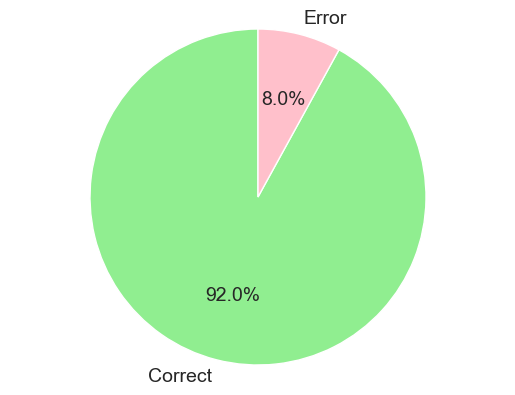

In [38]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Correct', 'Error'
sizes = [92, 8]
colors = ['lightgreen', 'pink']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.legend()
plt.show()

In [9]:
# Confusion Matrix divided by gender
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
# Creating a DataFrame for the confusion matrix with labels
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Non-Priority', 'Actual Priority'], 
                              columns=['Predicted Non-Priority', 'Predicted Priority'])

print("Confusion Matrix:\n", conf_matrix_df)

Confusion Matrix:
                      Predicted Non-Priority  Predicted Priority
Actual Non-Priority                      92                   0
Actual Priority                          11                  32


In [10]:
# Confusion matrix by gender
y_test_female = y_test[X_test['gender_encoded'] == 0]
y_pred_female = y_pred[X_test['gender_encoded'] == 0]
y_test_male = y_test[X_test['gender_encoded'] == 1]
y_pred_male = y_pred[X_test['gender_encoded'] == 1]

conf_matrix_female = confusion_matrix(y_test_female, y_pred_female)
conf_matrix_male = confusion_matrix(y_test_male, y_pred_male)

In [11]:
conf_matrix_female_df = pd.DataFrame(conf_matrix_female, 
                                     index=['Actual Non-Priority', 'Actual Priority'], 
                                     columns=['Predicted Non-Priority', 'Predicted Priority'])
female_precision, female_recall, female_f1_score, _ = precision_recall_fscore_support(y_test_female, y_pred_female, average='binary')
print("Confusion Matrix for Females:\n", conf_matrix_female_df)

Confusion Matrix for Females:
                      Predicted Non-Priority  Predicted Priority
Actual Non-Priority                      43                   0
Actual Priority                          11                   7


In [12]:
conf_matrix_male_df = pd.DataFrame(conf_matrix_male, 
                                   index=['Actual Non-Priority', 'Actual Priority'], 
                                   columns=['Predicted Non-Priority', 'Predicted Priority'])
male_precision, male_recall, male_f1_score, _ = precision_recall_fscore_support(y_test_male, y_pred_male, average='binary')
print("\nConfusion Matrix for Males:\n", conf_matrix_male_df)


Confusion Matrix for Males:
                      Predicted Non-Priority  Predicted Priority
Actual Non-Priority                      49                   0
Actual Priority                           0                  25


# Plots
## Measurements

In [13]:
def autolabel(bars):
    """Attach a text label above each bar in a bar chart."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

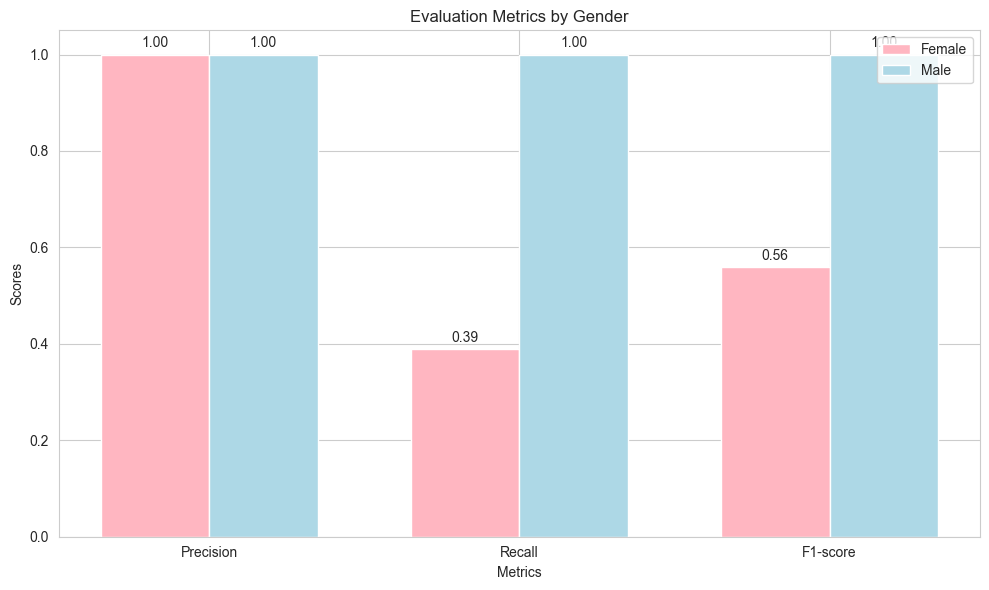

In [14]:
# Plot the different measurements by gender
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
metrics = ['Precision', 'Recall', 'F1-score']
index = np.arange(len(metrics))

bar1 = ax.bar(index - bar_width/2, [female_precision, female_recall, female_f1_score], bar_width, label='Female', color='lightpink')
bar2 = ax.bar(index + bar_width/2, [male_precision, male_recall, male_f1_score], bar_width, label='Male', color='lightblue')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics by Gender')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()
autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()

## Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

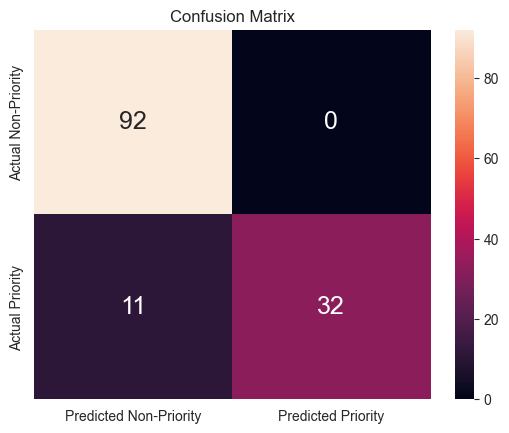

In [33]:
# General confusion matrix for all genders
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Predicted Non-Priority',  'Predicted Priority'], yticklabels=['Actual Non-Priority',  'Actual Priority'], annot_kws={"size": 18})
plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')

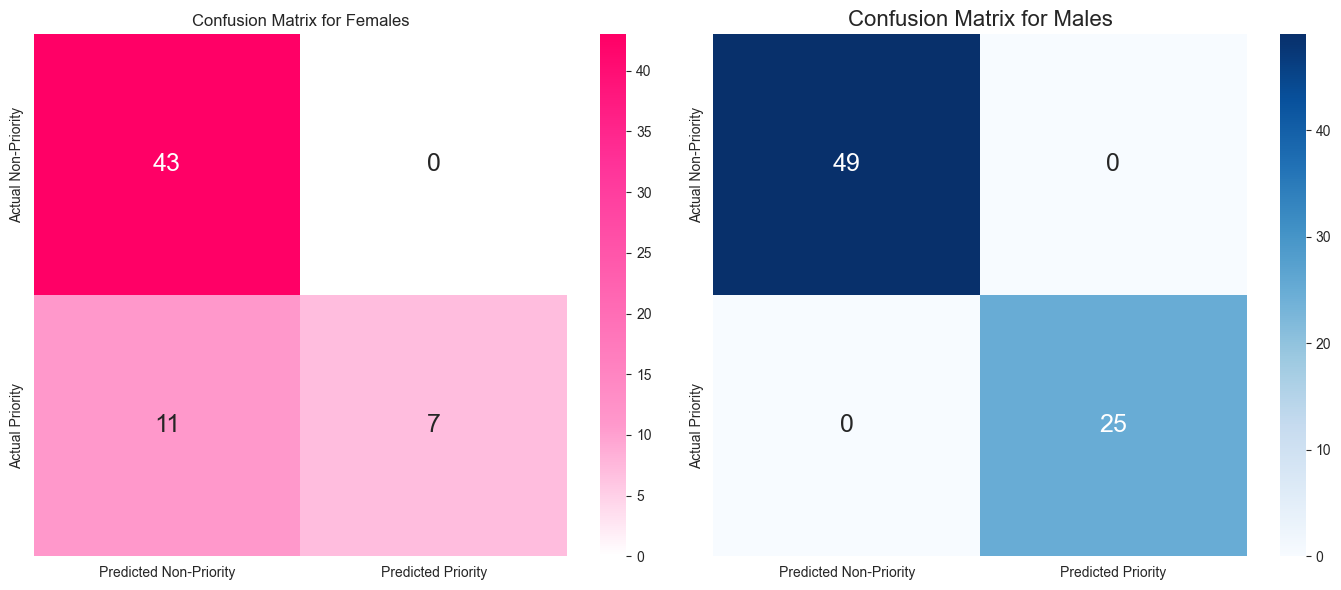

In [39]:
# Confusion matrix by gender
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pink_colors = ["#ffffff", "#ff99cc", "#ff66b2", "#ff3399", "#ff0066"]
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", pink_colors)
sns.heatmap(conf_matrix_female, annot=True, fmt='d', cmap=pink_cmap, ax=axes[0], xticklabels=['Predicted Non-Priority',  'Predicted Priority'], yticklabels=['Actual Non-Priority',  'Actual Priority'], annot_kws={"size": 18})
axes[0].set_title('Confusion Matrix for Females')
# axes[0].set_xlabel('Predicted Labels')
# axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_male, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=['Predicted Non-Priority',  'Predicted Priority'], yticklabels=['Actual Non-Priority',  'Actual Priority'], annot_kws={"size": 18})
axes[1].set_title('Confusion Matrix for Males', fontsize=16)
# axes[1].set_xlabel('Predicted Labels')
# axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

## ROC Curve

ROC Curve: graphical representation of the trade-off between the true positive rate (TPR) and false positive rate (FPR) of a classifier for different thresholds. The area under the ROC curve (AUC) is a measure of how well a classifier can distinguish between classes.

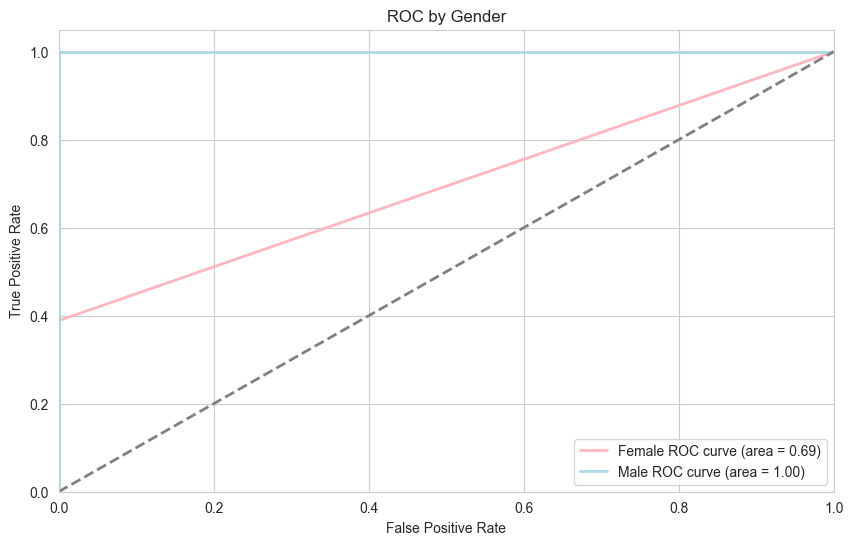

In [17]:
# Calculate ROC curves
fpr_female, tpr_female, _ = roc_curve(y_test_female, y_pred_female)
fpr_male, tpr_male, _ = roc_curve(y_test_male, y_pred_male)
roc_auc_female = auc(fpr_female, tpr_female)
roc_auc_male = auc(fpr_male, tpr_male)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_female, tpr_female, color='lightpink', lw=2, label=f'Female ROC curve (area = {roc_auc_female:.2f})')
plt.plot(fpr_male, tpr_male, color='lightblue', lw=2, label=f'Male ROC curve (area = {roc_auc_male:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC by Gender')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curves

Explanation of Precision-Recall Curves:
Instead of using the predicted labels (which are derived by applying a fixed threshold), the function uses the raw predicted probabilities of the positive class. This allows it to evaluate performance across all possible thresholds.
For each unique probability threshold (sorted in descending order), the function:
Assigns positive labels to samples with predicted probabilities above the threshold.
Computes the number of true positives, false positives, and false negatives based on these assignments.
Calculates precision and recall for this threshold.

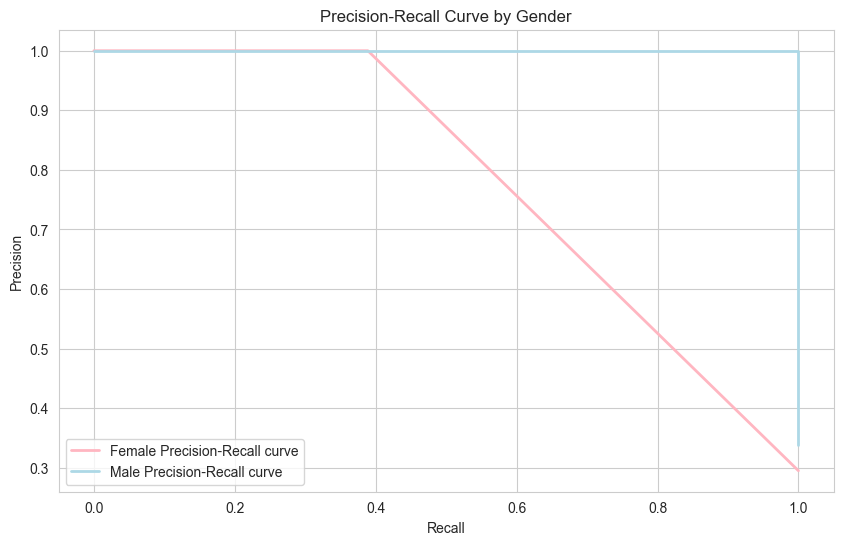

In [18]:
# Calculate Precision-Recall curves
precision_female, recall_female, _ = precision_recall_curve(y_test_female, y_pred_female)
precision_male, recall_male, _ = precision_recall_curve(y_test_male, y_pred_male)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_female, precision_female, color='lightpink', lw=2, label='Female Precision-Recall curve')
plt.plot(recall_male, precision_male, color='lightblue', lw=2, label='Male Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve by Gender')
plt.legend(loc="lower left")
plt.show()

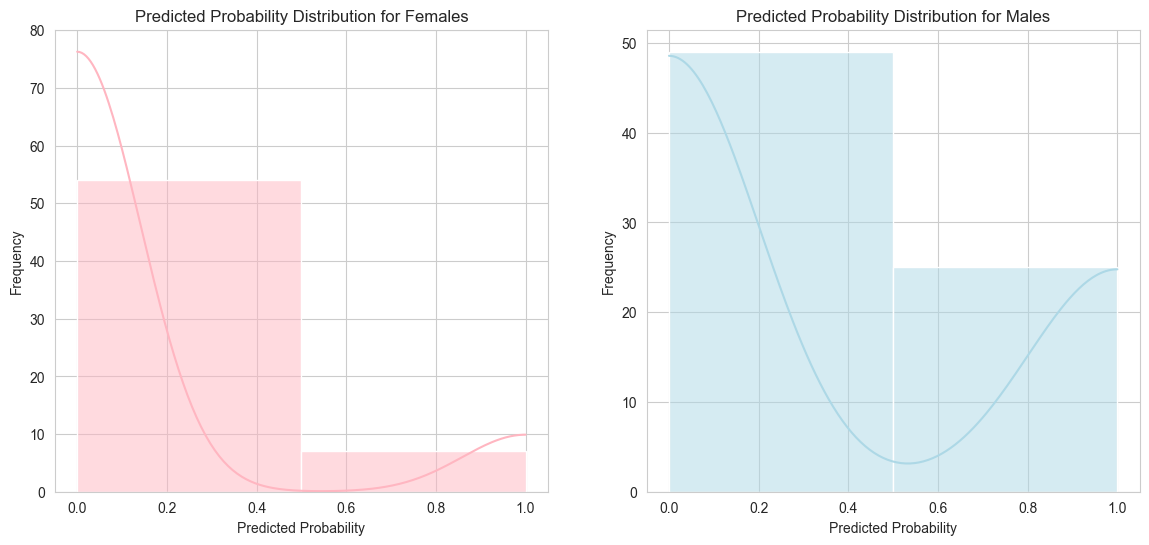

In [19]:
# Plot the predicted probability distribution for each gender
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(y_pred_female, bins=2, kde=True, color='lightpink', ax=ax[0])
ax[0].set_title('Predicted Probability Distribution for Females')
ax[0].set_xlabel('Predicted Probability')
ax[0].set_ylabel('Frequency')

sns.histplot(y_pred_male, bins=2, kde=True, color='lightblue', ax=ax[1])
ax[1].set_title('Predicted Probability Distribution for Males')
ax[1].set_xlabel('Predicted Probability')
ax[1].set_ylabel('Frequency')

plt.show()


In [20]:
# Compute Pearson correlation coefficient
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Pearson Correlation Coefficient between predictions and actual target: {correlation:.2f}")
female_correlation = np.corrcoef(y_test_female, y_pred_female)[0, 1]
print(f"Pearson Correlation Coefficient between predictions and actual target for female: {female_correlation:.2f}")
male_correlation = np.corrcoef(y_test_male, y_pred_male)[0, 1]
print(f"Pearson Correlation Coefficient between predictions and actual target for male: {male_correlation:.2f}")

Pearson Correlation Coefficient between predictions and actual target: 0.82
Pearson Correlation Coefficient between predictions and actual target for female: 0.56
Pearson Correlation Coefficient between predictions and actual target for male: 1.00
